# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. 
Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 
Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

__Признаки:__  
`RowNumber` — индекс строки в данных  
`CustomerId` — уникальный идентификатор клиента  
`Surname` — фамилия  
`CreditScore` — кредитный рейтинг  
`Geography` — страна проживания  
`Gender` — пол  
`Age` — возраст  
`Tenure` — количество недвижимости у клиента  
`Balance` — баланс на счёте  
`NumOfProducts` — количество продуктов банка, используемых клиентом  
`HasCrCard` — наличие кредитной карты  
`IsActiveMember` — активность клиента  
`EstimatedSalary` — предполагаемая зарплата  

__Целевой признак__:  
`Exited` — факт ухода клиента

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, f1_score, roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve

# 1. Подготовка данных

Импортирование, просмотр информации о полях (признаках), преобразования типов при необходимости, выявление пропусков, исследование на возможность заполнения пропусков.

In [3]:
df = pd.read_csv('/datasets/Churn.csv')
df.set_index('RowNumber', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


In [4]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.isna().sum()

CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

В процессе загрузки данных и первичного анализа были обнаружены пропуски в поле `Tenure` (количество недвижимости у клиента).

Попробуем заполнить эти пропуски в несколько этапов:  
- рассмотрим вариант со средним значением (медианой);
- если предыдущий этап не подойдет, то рассмотрим вариант зависимости от какого-либо другого признака;
- если таких признаков нет, то, поскольку этот признак количественный, применим алгоритмы регрессионных моделей.


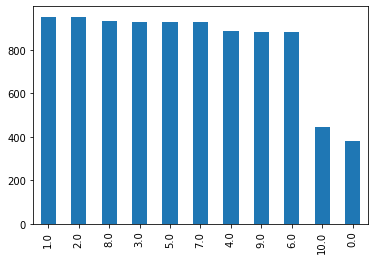

In [6]:
df.Tenure.value_counts().plot(kind='bar');

In [7]:
df.Tenure.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Tenure,9091.0,4.99769,2.894723,0.0,2.0,5.0,7.0,10.0


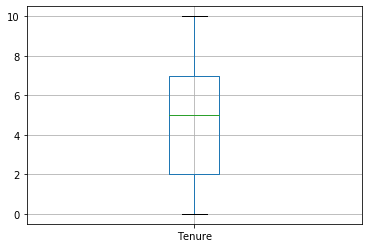

In [8]:
df.Tenure.to_frame().boxplot();

Среднее значение и медиана почти совпадают, и на мой взгляд, пропуски в этом поле вполне можно заменить на медиану.  

Но все же смущает тот факт, что в банковском деле при принятии решения о кредите даже наличие одной недвижимости уже очень важно, также как и каждой последующей... Поэтому хотелось бы более точного результата. К тому же разброс данных достаточного большой для такого важного признака.  

Попробуем проанализировать какие-либо зависимости от других признаков.

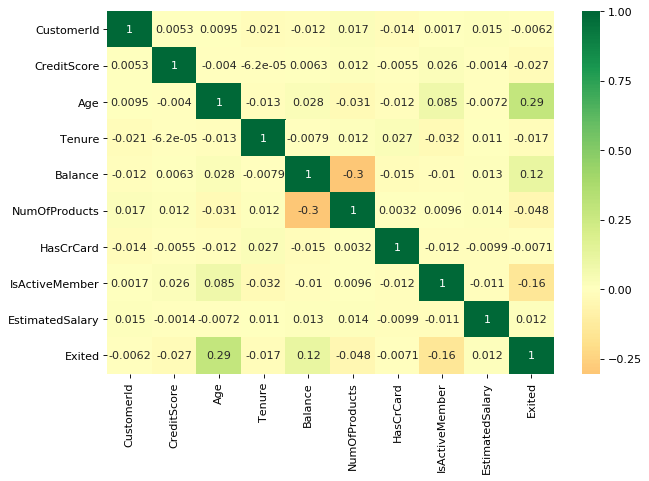

In [9]:
# матрица корреляций

plt.figure(figsize=(9,6), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.show()

Как видно из диаграммы, наш признак взаимно не коррелируется с прочими признаками, а значит нужно рассматривать ее зависимость в комплексе со всеми прочими признаками. Поэтому применим модели регрессионных алгоритмов для заполнения пропусков, а именно - случайного леса, выберем наилучший по RMSE и заполним пропуски.

Целевым признаком будет `Tenere`, а тестовой выборкой - все данные, у которых этот признак пропущен.

Но предварительно преобразуем категориальные поля `Geography` и `Gender` техникой __порядкового кодирования__.

In [10]:
columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
           'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

df1 = df[['Geography', 'Gender']]
encoder = OrdinalEncoder()
encoder.fit(df1)
df_ordinal = pd.DataFrame(encoder.transform(df1), columns=['Geography', 'Gender'], index=df1.index)
df_ordinal = df_ordinal.join(df[columns])
df_ordinal.head()

,Geography,Gender,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,0.0,0.0,619,42,2.0,0.00,1,1,1,101348.88,1
2,2.0,0.0,608,41,1.0,83807.86,1,0,1,112542.58,0
3,0.0,0.0,502,42,8.0,159660.80,3,1,0,113931.57,1
4,0.0,0.0,699,39,1.0,0.00,2,0,0,93826.63,0
5,2.0,0.0,850,43,2.0,125510.82,1,1,1,79084.10,0


In [11]:
features = df_ordinal.query('~Tenure.isna()').drop(['Tenure'] , axis=1)
target = df_ordinal.query('~Tenure.isna()')['Tenure']
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
features_train.shape, features_valid.shape, target_train.shape, target_valid.shape

((6818, 10), (2273, 10), (6818,), (2273,))

In [12]:
scores = []
for depth in 2,3,4:
    for n_estimators in range(6, 31, 2):
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        mse = mean_squared_error(target_valid, predicted_valid)
        row = [depth, n_estimators, mse ** 0.5]
        scores.append(row)

df_scores = pd.DataFrame(scores, columns=['depth', 'n_estimators', 'rmse'])
df_scores.head()

,depth,n_estimators,rmse
0,2,6,2.866548
1,2,8,2.865349
2,2,10,2.866548
3,2,12,2.866852
4,2,14,2.866167


In [13]:
# параметры для минимального rmse
min_params = df_scores[df_scores.rmse == df_scores.rmse.min()]
min_params

,depth,n_estimators,rmse
20,3,20,2.863751


Таким образом, для заполнения пропусков признака `Tenure` будем использовать модель случайного леса с параметрами: 
`max_depth = 3` и `n_estimators = 20`

In [14]:
tenure_isna = df_ordinal.query('Tenure.isna()').drop(['Tenure'] , axis=1)

model = RandomForestRegressor(n_estimators=20, max_depth=3, random_state=12345)
model.fit(features_train, target_train)
predicted_tenure = pd.DataFrame(model.predict(tenure_isna), columns=['Tenure'], index=tenure_isna.index).round().astype('int')
predicted_tenure.head()

,Tenure
RowNumber,
31,5
49,5
52,5
54,5
61,5


In [15]:
predicted_tenure.Tenure.value_counts()

5    907
6      1
4      1
Name: Tenure, dtype: int64

#### Вывод:

__Как показали результаты расчета, полученные значения почти не отличаются от медианы. Поэтому пропуски признака `Tenure` заполним медианой.__

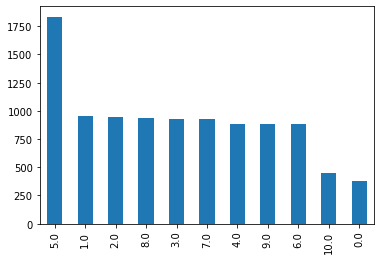

In [16]:
df_ordinal.loc[[row for row in predicted_tenure.index], 'Tenure'] = 5
df_ordinal.Tenure.value_counts().plot(kind='bar');

***

# 2. Исследование задачи

По условию задания нам нужно построить модель с предельно большим значением F1-меры, но не менее 0.59.  

Для этого будем применять модели случайного леса и логистической регрессии.  

In [17]:
# ранее мы уже преобразовали категориальные признаки и получили 
# таблицу df_ordinal, которую и будем использовать далее

# проверка целевого признака
df_ordinal.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Определение из курса: __"Классы не сбалансированны, когда их соотношение далеко от 1:1."__  

Поскольку у нас количество одного класса почти в 4 раза больше другого, следовательно - классы не сбалансированные.  

Далее обучим и исследуем модели на текущих данных. Если не получится достичь значения 0,59 метрики F1, то попытаемся улучшить качество модели, учитывая дисбаланс классов.

In [18]:
# разбивка данных на тренировочные, валидационные и тестовые

features = df_ordinal.drop('Exited', axis=1)
target = df_ordinal['Exited']

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
                                                                              test_size=0.25, random_state=12345)

In [19]:
data_shapes = {'type':['тренировочные', 'валидационные', 'тестовые'], 
               'shape': [(features_train.shape, target_train.shape),
                         (features_valid.shape, target_valid.shape),
                         (features_test.shape, target_test.shape),
                        ]
              }
pd.DataFrame(data_shapes)

,type,shape
0,тренировочные,"((6000, 10), (6000,))"
1,валидационные,"((2000, 10), (2000,))"
2,тестовые,"((2000, 10), (2000,))"


In [20]:
%%time

# Случайный лес. 
# Расчет моделей для четных max_depth от 2 до 30, n_estimators от 1 до 30 и выбор модели с наилучшим результатом

scores = []
for depth in range(2, 31, 2):
    for n_estimators in range(1,31):
        model = RandomForestClassifier(random_state=12345, n_estimators=n_estimators, max_depth=depth)
        model.fit(features_train, target_train)
        valid_prediction = model.predict(features_valid)
        f1 = f1_score(target_valid, valid_prediction)

        probabilities_valid = model.predict_proba(features_valid)
        auc_roc = roc_auc_score(target_valid, probabilities_valid[:,1])
        scores.append(['{}_{}'.format(depth, n_estimators), f1, auc_roc])
   

CPU times: user 1min 9s, sys: 120 ms, total: 1min 9s
Wall time: 1min 9s


In [21]:
scores_df = pd.DataFrame(scores, columns=['depth_n_estimators', 'f1_score', 'roc_auc_score'])
scores_df.sort_values('f1_score', ascending=False).head()

,depth_n_estimators,f1_score,roc_auc_score
322,22_23,0.563780,0.831526
316,22_17,0.562597,0.819244
315,22_16,0.561404,0.817116
208,14_29,0.560897,0.835953
260,18_21,0.560386,0.834216


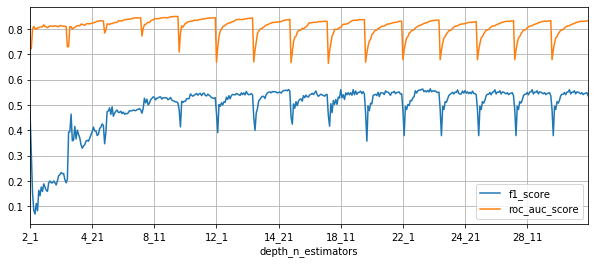

In [22]:
scores_df.plot(x='depth_n_estimators', grid=True, figsize=(10, 4));

In [23]:
# логистическая регрессия
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
valid_prediction = model.predict(features_valid)
f1 = f1_score(target_valid, valid_prediction)

probabilities_valid = model.predict_proba(features_valid)
auc_roc = roc_auc_score(target_valid, probabilities_valid[:,1])

print('LogisticRegression: f1_score = {:.5f}, roc_auc_score = {:.5f}'.format(f1, auc_roc))


LogisticRegression: f1_score = 0.10291, roc_auc_score = 0.68122


#### Вывод:

Максимальное значение `F1`-метрики (0,564) получилось для модели случайного леса с параметрами `max_depth=22` и `n_estimators=23`.  
Но полученное значение не дотягивает до требуемого (0,59), поэтому попытаемся улучшить качество модели.
***

# 3. Борьба с дисбалансом

Проведем следующие действия для борьбы с дисбалансом классов:

- расчет моделей с учетом взвешивания классов;
- увеличение выборки меньшего класса;
- уменьшение выборки большего класса

#### Расчет с учетом взвешенности классов

In [24]:
%%time

# Случайный лес. 

scores = []
for depth in range(2, 31, 2):
    for n_estimators in range(1,31):
        model = RandomForestClassifier(random_state=12345, n_estimators=n_estimators, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        valid_prediction = model.predict(features_valid)
        f1 = f1_score(target_valid, valid_prediction)

        probabilities_valid = model.predict_proba(features_valid)
        auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
        scores.append(['{}_{}'.format(depth, n_estimators), f1, auc_roc])

CPU times: user 1min 8s, sys: 156 ms, total: 1min 8s
Wall time: 1min 9s


In [25]:
scores_df = pd.DataFrame(scores, columns=['depth_n_estimators', 'f1_score', 'roc_auc_score'])
scores_df.sort_values('f1_score', ascending=False).head()

,depth_n_estimators,f1_score,roc_auc_score
89,6_30,0.583691,0.852977
87,6_28,0.583514,0.853075
88,6_29,0.583514,0.853238
142,10_23,0.582375,0.843654
86,6_27,0.578603,0.852893


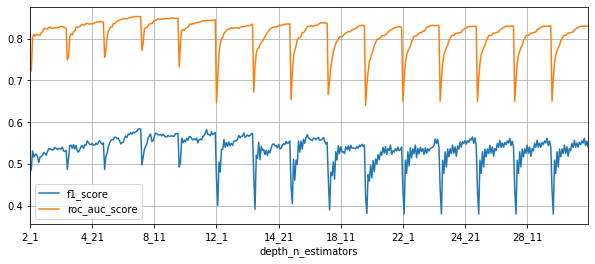

In [26]:
scores_df.plot(x='depth_n_estimators', grid=True, figsize=(10, 4));

In [27]:
# логистическая регрессия
model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
valid_prediction = model.predict(features_valid)
f1 = f1_score(target_valid, valid_prediction)

probabilities_valid = model.predict_proba(features_valid)
auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
print('LogisticRegression: f1_score = {:.5f}, roc_auc_score = {:.5f}'.format(f1, auc_roc))


LogisticRegression: f1_score = 0.47276, roc_auc_score = 0.75955


Применение взвешенности классов привело к росту метрик и максимальная f1-мера достигла значения 0,584.  
Но мы опять не достигли нужного нам порога в 0,59!  
Продолжим улучшать качестов моделей другими способами.
***

#### Увеличение выборки

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target_train == 0]
    features_ones = features[target_train == 1]
    target_zeros = target[target_train == 0]
    target_ones = target[target_train == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    return shuffle(features_upsampled), shuffle(target_upsampled)
    

In [29]:
%%time
# Случайный лес. 
scores = []
for repeat in 2,3,4:
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    for depth in range(2, 31, 2):
        for n_estimators in range(1,31):
            model = RandomForestClassifier(random_state=12345, n_estimators=n_estimators, max_depth=depth)
            model.fit(features_upsampled, target_upsampled)
            valid_prediction = model.predict(features_valid)
            f1 = f1_score(target_valid, valid_prediction)

            probabilities_valid = model.predict_proba(features_valid)
            auc_roc = roc_auc_score(target_valid, probabilities_valid[:,1])
            scores.append(['{}_{}_{}'.format(repeat, depth, n_estimators), f1, auc_roc])


CPU times: user 5min 29s, sys: 504 ms, total: 5min 29s
Wall time: 5min 34s


In [30]:
scores_df = pd.DataFrame(scores, columns=['repeat_depth_estimators', 'f1_score', 'roc_auc_score'])
scores_df['059'] = 0.59
scores_df.sort_values('f1_score', ascending=False).head()

,repeat_depth_estimators,f1_score,roc_auc_score,059
1327,4_30_8,0.306138,0.517193,0.59
915,4_2_16,0.301991,0.498834,0.59
928,4_2_29,0.301887,0.509521,0.59
929,4_2_30,0.301384,0.500006,0.59
917,4_2_18,0.301018,0.495766,0.59


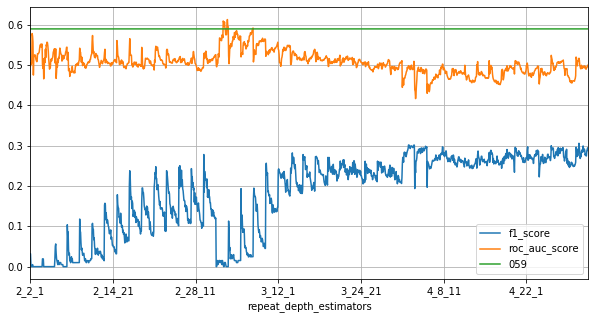

In [31]:
scores_df.plot(x='repeat_depth_estimators', grid=True, figsize=(10, 5));

In [32]:
%%time
# логистическая регрессия

print('LogisticRegression: ')
for repeat in 2,3,4:
    model = LogisticRegression(random_state=12345)
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    model.fit(features_upsampled, target_upsampled)
    valid_prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, valid_prediction)

    probabilities_valid = model.predict_proba(features_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
    print('repeat = {} f1_score = {:.5f}, roc_auc_score = {:.5f}'.format(repeat, f1, auc_roc))


LogisticRegression: 
repeat = 2 f1_score = 0.00000, roc_auc_score = 0.55913
repeat = 3 f1_score = 0.00000, roc_auc_score = 0.48911
repeat = 4 f1_score = 0.33375, roc_auc_score = 0.55797
CPU times: user 312 ms, sys: 340 ms, total: 652 ms
Wall time: 628 ms


#### Вывод
Увеличение выборки приводит к снижению нашего показателя F1.  
Попробуем способ с уменьшением выборки.
***

#### Уменьшение выборки

In [33]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_zeros_downsampled = features_zeros.sample(frac=fraction, random_state=12345)
    features_downsampled = pd.concat([features_zeros_downsampled] + [features_ones])
    target_zeros_downsampled = target_zeros.sample(frac=fraction, random_state=12345)
    target_downsampled = pd.concat([target_zeros_downsampled] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

In [34]:
%%time
# Случайный лес. 
scores = []
for frac in 0.25, 0.4, 0.5:
    features_downsampled, target_downsampled = downsample(features_train, target_train, frac)
    for depth in range(2, 31, 2):
        for n_estimators in range(1,31):
            model = RandomForestClassifier(random_state=12345, n_estimators=n_estimators, max_depth=depth)
            model.fit(features_downsampled, target_downsampled)
            valid_prediction = model.predict(features_valid)
            f1 = f1_score(target_valid, valid_prediction)

            probabilities_valid = model.predict_proba(features_valid)
            auc_roc = roc_auc_score(target_valid, probabilities_valid[:,1])
            scores.append(['{}_{}_{}'.format(frac, depth, n_estimators), f1, auc_roc])

CPU times: user 2min 11s, sys: 408 ms, total: 2min 12s
Wall time: 2min 13s


In [35]:
scores2_df = pd.DataFrame(scores, columns=['frac_depth_estimators', 'f1_score', 'roc_auc_score'])
scores2_df.sort_values('f1_score', ascending=False).head()

,frac_depth_estimators,f1_score,roc_auc_score
1249,0.5_24_20,0.596026,0.826750
1279,0.5_26_20,0.596026,0.826750
1309,0.5_28_20,0.596026,0.826750
1339,0.5_30_20,0.596026,0.826750
1310,0.5_28_21,0.595208,0.825694


In [36]:
scores2_df.query('f1_score >= 0.59').describe()

,f1_score,roc_auc_score
count,33.000000,33.000000
mean,0.593080,0.828860
std,0.001633,0.002986
min,0.590674,0.824584
25%,0.591837,0.825694
50%,0.592790,0.827844
75%,0.593377,0.831547
max,0.596026,0.832842


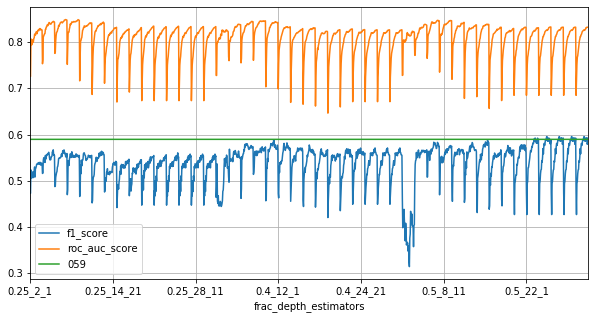

In [37]:
scores2_df['059'] = 0.59
scores2_df.plot(x='frac_depth_estimators', grid=True, figsize=(10, 5));

Итак, мы получили модели, при которых метрика f1-мера получается больше 0.59.  

На диаграмме показана линия значения 0.59 и значений f1-меры для разных параметров fraction для уменьшения выборки, а также параметров max_depth и n_estimators для алгоритма случайного дерева.  

Количество моделей, у которых f1-мера больше 0.59, более тридцати.  
Все они были получены при уменьшении трениновочной выборки в 2 раза (fraction = 0.5).  

Максимальное значение f1-меры равна 0.596026 при max_depth=24 и n_estimators=20.

Можно на этом и остановиться, но разберем еще модель логистической регрессии.


In [38]:
# логистическая регрессия

print('LogisticRegression: ')
for frac in 0.25, 0.4, 0.5:
    model = LogisticRegression(random_state=12345)
    features_downsampled, target_downsampled = downsample(features_train, target_train, frac)

    model.fit(features_train, target_train)
    valid_prediction = model.predict(features_valid)
    f1 = f1_score(target_valid, valid_prediction)

    probabilities_valid = model.predict_proba(features_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
    print('repeat = {} f1_score = {:.5f}, roc_auc_score = {:.5f}'.format(repeat, f1, auc_roc))


LogisticRegression: 
repeat = 4 f1_score = 0.10291, roc_auc_score = 0.68122
repeat = 4 f1_score = 0.10291, roc_auc_score = 0.68122
repeat = 4 f1_score = 0.10291, roc_auc_score = 0.68122


Качество модели никак не улучшается на алгоритме логистической регрессии при уменьшении выборки на тренировочных данных.  

### Вывод:

Для борьбы с дисбалансом классов были использованы следующие методы:  
- учет взвешенности классов;
- увеличение выборки меньшего класса;
- уменьшение выборки большего класса.

При этом наибольший прирост показателя f1-мера были достигнут при применении последнего способа - уменьшение выборки в 2 раза - на алгоритмах случайного леса.  
При этом мы выявили параметры нескольких моделей, при которых метрика f1 превышает заданный нам порог 0,59.
Далее проведем тестирование на этих моделях.
***

# 4. Тестирование модели

In [39]:
# оставим в таблице только те модели, у которых f1 более 0,59
scores_059 = scores2_df.query('f1_score >= 0.59')

scores_059['max_depth'] = scores_059['frac_depth_estimators'].apply(lambda x: x.split('_')[1])
scores_059['n_estimators'] = scores_059['frac_depth_estimators'].apply(lambda x: x.split('_')[2])
scores_059.max_depth = scores_059.max_depth.astype('int')
scores_059.n_estimators = scores_059.n_estimators.astype('int')
scores_059.head()

,frac_depth_estimators,f1_score,roc_auc_score,059,max_depth,n_estimators
1219,0.5_22_20,0.591327,0.825685,0.59,22,20
1221,0.5_22_22,0.592885,0.824584,0.59,22,22
1227,0.5_22_28,0.592593,0.831008,0.59,22,28
1248,0.5_24_19,0.591837,0.825430,0.59,24,19
1249,0.5_24_20,0.596026,0.826750,0.59,24,20


In [40]:
# исследование на тестовых данных

f1_score_for_test = []
for idx in scores_059.index:
    n_estim = scores_059.loc[idx, 'n_estimators']
    depth = scores_059.loc[idx, 'max_depth']
    model = RandomForestClassifier(random_state=12345, n_estimators=n_estim, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    valid_prediction = model.predict(features_test)
    f1 = f1_score(target_test, valid_prediction)
    probabilities_valid = model.predict_proba(features_test)
    auc_roc = roc_auc_score(target_test, probabilities_valid[:, 1])

    f1_score_for_test.append([f1, auc_roc])

scores_059 = scores_059.join(pd.DataFrame(f1_score_for_test, 
                                          columns=['f1_test', 'roc_test'], 
                                          index=scores_059.index))
scores_059.head()    

,frac_depth_estimators,f1_score,roc_auc_score,059,max_depth,n_estimators,f1_test,roc_test
1219,0.5_22_20,0.591327,0.825685,0.59,22,20,0.607013,0.847246
1221,0.5_22_22,0.592885,0.824584,0.59,22,22,0.610706,0.847338
1227,0.5_22_28,0.592593,0.831008,0.59,22,28,0.610577,0.850701
1248,0.5_24_19,0.591837,0.825430,0.59,24,19,0.608092,0.848497
1249,0.5_24_20,0.596026,0.826750,0.59,24,20,0.613718,0.848735


In [41]:
scores_059.describe()

,f1_score,roc_auc_score,059,max_depth,n_estimators,f1_test,roc_test
count,33.000000,33.000000,33.00,33.000000,33.000000,33.000000,33.000000
mean,0.593080,0.828860,0.59,26.727273,23.575758,0.613010,0.849007
std,0.001633,0.002986,0.00,2.589314,3.509187,0.004679,0.001342
min,0.590674,0.824584,0.59,22.000000,19.000000,0.605042,0.847246
25%,0.591837,0.825694,0.59,24.000000,20.000000,0.610577,0.848079
50%,0.592790,0.827844,0.59,26.000000,23.000000,0.612245,0.848562
75%,0.593377,0.831547,0.59,28.000000,26.000000,0.615741,0.848844
max,0.596026,0.832842,0.59,30.000000,30.000000,0.620047,0.851894


In [42]:
# параметрый для максимального значения f1
max_score = scores_059[scores_059['f1_test'] == scores_059['f1_test'].max()]
max_score

,frac_depth_estimators,f1_score,roc_auc_score,059,max_depth,n_estimators,f1_test,roc_test
1254,0.5_24_25,0.593068,0.831486,0.59,24,25,0.620047,0.848562
1284,0.5_26_25,0.593068,0.831486,0.59,26,25,0.620047,0.848562
1314,0.5_28_25,0.593068,0.831486,0.59,28,25,0.620047,0.848562
1344,0.5_30_25,0.593068,0.831486,0.59,30,25,0.620047,0.848562


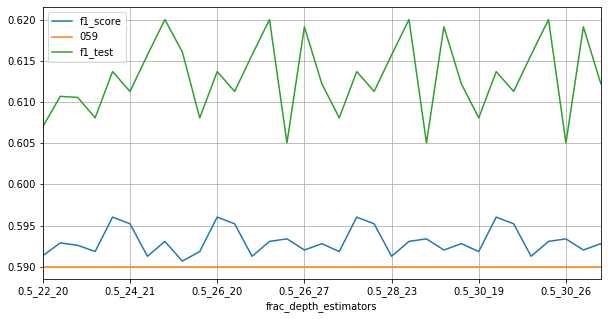

In [43]:
scores_059[['frac_depth_estimators', 'f1_score', '059','f1_test']].plot(x='frac_depth_estimators', 
                                                                        grid=True, figsize=(10, 5));

На выбранных моделях тестовые данные показали даже лучшие значения метрики f1. А максимальное значение было достигнуто сразу на 4 моделях и составило 0,62.  

При этом максимальные значения метрики AUC-ROC достигается совсем на других моделях. Но разница незначительная.   
Рассмотрим сравнительную диаграмму.

In [44]:
# добавим в max_score параметрый для максимального значения auc_roc

max_score = pd.concat([max_score, scores_059[scores_059['roc_test'] == scores_059['roc_test'].max()]])
max_score

,frac_depth_estimators,f1_score,roc_auc_score,059,max_depth,n_estimators,f1_test,roc_test
1254,0.5_24_25,0.593068,0.831486,0.59,24,25,0.620047,0.848562
1284,0.5_26_25,0.593068,0.831486,0.59,26,25,0.620047,0.848562
1314,0.5_28_25,0.593068,0.831486,0.59,28,25,0.620047,0.848562
1344,0.5_30_25,0.593068,0.831486,0.59,30,25,0.620047,0.848562
1289,0.5_26_30,0.592790,0.832583,0.59,26,30,0.612245,0.851894
1319,0.5_28_30,0.592790,0.832583,0.59,28,30,0.612245,0.851894
1349,0.5_30_30,0.592790,0.832583,0.59,30,30,0.612245,0.851894


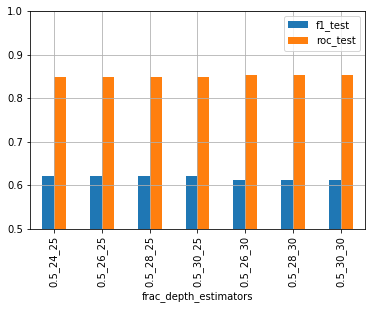

In [45]:
max_score[['frac_depth_estimators', 'f1_test', 'roc_test']]. \
    plot(x='frac_depth_estimators', kind='bar', grid=True, ylim=[0.5, 1.]);

Последние 3 пары столбцов соответствуют максимальному значению auc_roc. Зрительно эти значения совсем не отличаются от значений auc_roc предыдущих 4 столбцов.  
Можно сделать предположение, что метрики f1 и auc_roc почти равно значны. Следовательно, для измерения качества модели можно использовать ту или другую меру.

Напоследок, приведем roc-кривую для одной из максимальных моделей. 

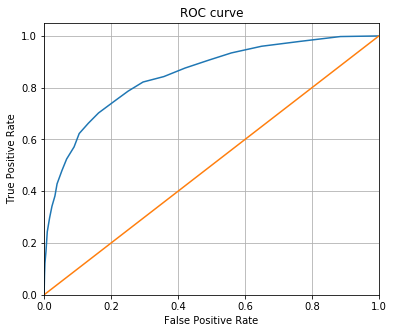

In [46]:
n_estim = scores_059.loc[max_score.index[0], 'n_estimators']
depth = scores_059.loc[max_score.index[0], 'max_depth']
model = RandomForestClassifier(random_state=12345, n_estimators=n_estim, max_depth=depth)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_test)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_valid[:,1], pos_label=1)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.grid(True)
plt.show()